In [1]:
# importing key packages
import os
import random
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.raman.sample_builder import SampleBuilder
from src.raman.sample import Sample
random.seed(42)
from src.raman.constants import Label

In [2]:
def split_train_val_test(sample_list, train_frac, val_frac):
    train_num = int(len(sample_list)*train_frac)
    val_num = int(len(sample_list)*val_frac)
    test_num = len(sample_list) - train_num - val_num
    assert train_num != 0 or train_frac == 0, 'train fraction too small'
    assert val_num !=0 or val_frac == 0, 'val fraction too small'
    index_list = random.shuffle([i for i in range(0, len(sample_list))])
    train_vals = sample_list[index_list[0:train_num]]
    val_vals = sample_list[index_list[train_num: val_num]]
    test_vals = sample_list[index_list[val_num:-1]]

    return train_vals, val_vals, test_vals

def make_df(sample_list):
    df = pd.DataFrame()
    for sample in sample_list:
        df = df.append(sample.to_pandas(), ignore_index=True)

    return df

def get_X_Y(df, remove_maybe_uncat=True):
    if remove_maybe_uncat:
        df = df[(df['label'] == Label.GOOD ) | (df['label'] == Label.BAD)]
        print(df)
        
        
    X = np.stack(df['spectrum'].to_numpy())
    Y_obj = df['label'].to_numpy()
    Y = np.array([y.value for y in Y_obj])
    #X = np.array([x.data for x in X])
    return X, Y

In [3]:
# Set Directory of Labeled raman data and split into test, train val
labeled_data_dir = '/Users/dda/Code/ramanbox/data/labeled_data/'
net_cdf_files = glob.glob(os.path.join(labeled_data_dir, '*.nc'))
sample_list = []
for file in net_cdf_files:
    sample_list.append(Sample.build_from_netcdf(file))
print(len(sample_list))

5


In [4]:
train_samples = sample_list[:3]
val_samples = sample_list[3:4]
test_samples = sample_list[4:]
#train_samples, val_samples, test_samples = split_train_val_test(sample_list, 2.0/5.0, 2.0/5.0)

In [5]:
# make a training test and val dataframe
train_df = make_df(train_samples)
train_df.label.unique()


array([<Label.GOOD: 1>, <Label.UNCAT: 3>, <Label.BAD: 0>], dtype=object)

In [6]:
val_df = make_df(val_samples)
test_df = make_df(test_samples)
print(train_df.columns)

Index(['spectrum', 'label', 'x_pos', 'y_pos', 'name'], dtype='object')


In [7]:
X_train, y_train = get_X_Y(train_df)
X_val, y_val = get_X_Y(val_df)
X_test, y_test = get_X_Y(test_df)

X_test[0].data

                                               spectrum       label  x_pos  \
0     [18.756165120223844, 19.054400977376893, 19.57...  Label.GOOD      0   
1     [16.40678608045157, 16.39639504180089, 16.3663...  Label.GOOD      1   
2     [16.140213015032, 16.179035595141684, 16.15268...  Label.GOOD      2   
3     [18.715378414044686, 19.182728800518184, 18.75...  Label.GOOD      3   
4     [17.851638678373543, 18.274909886172818, 18.05...  Label.GOOD      4   
...                                                 ...         ...    ...   
1062  [19.474817506632007, 19.83757447141436, 19.891...  Label.GOOD      4   
1063  [16.72015267899529, 17.07758223638982, 16.5216...  Label.GOOD      5   
1064  [14.670077965568094, 14.82144766867377, 14.732...  Label.GOOD      6   
1065  [14.86976776461529, 15.523436745929086, 15.991...  Label.GOOD      7   
1066  [14.955558311219715, 15.46134629373064, 15.818...  Label.GOOD      8   

      y_pos                                               name 

In [8]:
X_test

array([[ 17.80669983,  17.898181  ,  17.48184585, ...,   3.72523131,
          3.6523788 ,   3.71189976],
       [ 19.36129614,  19.22188497,  18.71874571, ...,   4.33178517,
          4.04559499,   3.76622529],
       [ 20.83696917,  20.59799876,  19.9845477 , ...,   2.38904455,
          2.62901464,   2.45739535],
       ...,
       [142.71510721, 141.99669242, 140.71307684, ...,   9.06734057,
          9.14074958,   9.22093907],
       [ 78.03556807,  76.49742425,  76.42061711, ...,   5.89520814,
          5.54379504,   5.61304948],
       [ 41.20129628,  41.14331754,  40.50067176, ...,   3.21658141,
          2.96761425,   2.84866343]])

In [9]:
X_train.shape

(771, 1024)

In [10]:
#Build Models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from xgboost import XGBClassifier


/usr/local/anaconda3/envs/Labeler/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/anaconda3/envs/Labeler/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/local/anaconda3/envs/Labeler/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following

[10:12:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


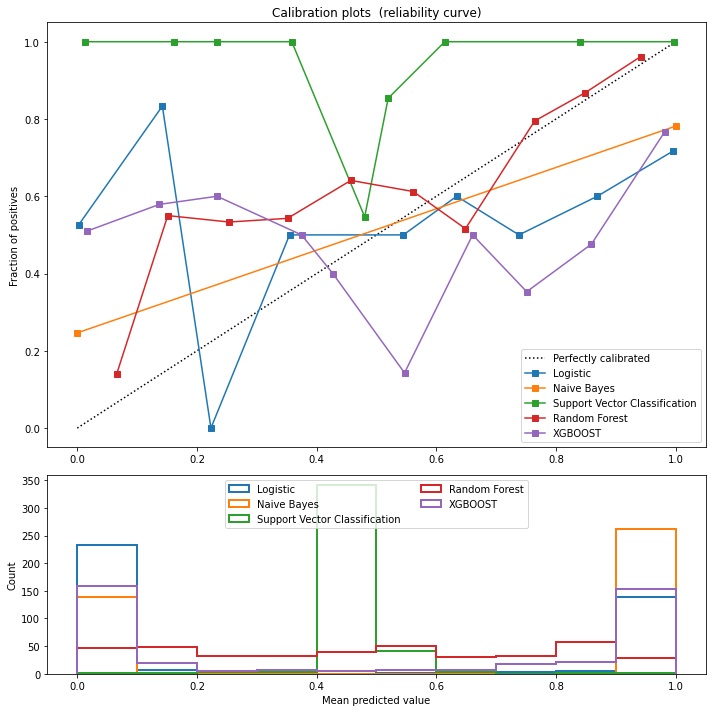

In [11]:
# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier()
xgb = XGBClassifier()

# #############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest'),
                   (xgb, 'XGBOOST')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

In [12]:
from sklearn.metrics import confusion_matrix
y_true = y_test
y_pred = rfc.predict(X_test)
confusion_matrix(y_true, y_pred)

array([[111,  50],
       [ 90, 148]])

In [13]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred)

0.6788990825688075

In [14]:
from joblib import dump, load
output_dir = '/Users/dda/Code/ramanbox/data/models'
output_file = os.path.join(output_dir, 'rfc.joblib')
dump(rfc, output_file)


['/Users/dda/Code/ramanbox/data/models/rfc.joblib']